Bean There Done That is a small-sized coffee roaster in the Netherlands, with an annual output of ±1,000 tonnes and <1% domestic market share. Despite offering premium specialty coffee, the company struggles to grow and needs to assess whether its operations and business model are ready to scale.  The challenge now is to evaluate whether current operations can sustainably handle renewed growth, and to identify bottlenecks in sourcing, production, and distribution. 

How can the company improve efficiency and scalability while maintaining premium quality, to grow in a highly competitive market? 

Roaster Utilization Rate (% of max capacity used) 
Shows if production capacity can handle more demand or if new investments are required. Production_kg / Max_possible_kg. 
Supplier Reliability (% on-time deliveries) 
Inventory Turnover (times stock is renewed yearly) 
On-Time Delivery Rate (% delivered as promised) 

In [22]:
import pandas as pd
 
# Load the Excel file
file_path = "Bean there done that data.xlsx"  
 
# Load the specific sheet with finished product inventory
inventory_fp = pd.read_excel(file_path, sheet_name="Inventory (finished product)")

excel = pd.ExcelFile(file_path)
print("Available sheets:", excel.sheet_names)  # This will show the sheet names

inventory_fp = pd.read_excel(file_path, sheet_name='Inventory (finished product)')
roasting = pd.read_excel(file_path, sheet_name='Roasting')
sales_ecom = pd.read_excel(file_path, sheet_name='E-com sales orders by product')
sales_b2b = pd.read_excel(file_path, sheet_name='B2B orders')

 
# Quick check: show first few rows
print(inventory_fp.head())

Available sheets: ['Inventory (raw material)', 'Inventory (finished product)', 'Roasting', 'E-com sales orders by product', 'B2B orders']
      Product     Month  Stock level Unit  Scrapped Reasoncode  Unit price  \
0  Dark roast   January        18660   Kg         0        NaN       22.98   
1  Dark roast  February        17290   Kg         0        NaN       22.98   
2  Dark roast     March        27231   Kg         0        NaN       22.98   
3  Dark roast     April        32511   Kg         0        NaN       22.98   
4  Dark roast       May        36683   Kg         0        NaN       22.98   

   Stock value  
0    428806.80  
1    397324.20  
2    625768.38  
3    747102.78  
4    842975.34  


In [23]:
# Do this for each DataFrame
for df in [inventory_fp, roasting, sales_ecom, sales_b2b]:
    df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]


In [24]:
# Clean columns: lowercase, remove leading/trailing spaces, replace spaces with underscores
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# View the cleaned column names
print("Cleaned columns:", df.columns.tolist())


Cleaned columns: ['customer', 'city', 'product', 'bag_type', 'quantity', 'value', 'delivery_date', 'shipping_costs']


In [25]:
print(df.head())
print(df.info())


          customer             city       product  bag_type  quantity   value  \
0  NextGen Offices           Arnhem  Medium Roast         1        56  1450.4   
1        DevOffice        Rotterdam  Medium Roast         1        67  1735.3   
2      Rent-a-desk         Nijmegen  Medium Roast         1        45  1165.5   
3      Desktoppers  s-Hertogenbosch  Medium Roast         1        70  1813.0   
4           WeWork        Amsterdam  Medium Roast         1        52  1346.8   

  delivery_date  shipping_costs  
0    2023-01-02              75  
1    2023-01-02              75  
2    2023-01-02              75  
3    2023-01-02              75  
4    2023-01-02              75  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customer        273 non-null    object        
 1   city            273 non-null    object      

In [26]:
# Convert relevant columns to numbers, coerce errors to NaN
for col in ['stock_level', 'purchased', 'unit_price', 'stock_value', 'scrapped']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


In [27]:
print("Missing values per column:\n", df.isnull().sum())


Missing values per column:
 customer          0
city              0
product           0
bag_type          0
quantity          0
value             0
delivery_date     0
shipping_costs    0
dtype: int64


In [28]:
df = df.dropna(subset=['quantity', 'value'])


In [29]:
# Map month strings to numbers
inventory_fp['month_num'] = inventory_fp['month'].map({
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
})

avg_stock_monthly = inventory_fp.groupby('month_num')['stock_level'].mean()


In [30]:
# Convert dates to datetime if needed
if 'order_date' in sales_ecom.columns:
    sales_ecom['order_date'] = pd.to_datetime(sales_ecom['order_date'])
    sales_ecom['month'] = sales_ecom['order_date'].dt.month

if 'delivery_date' in sales_b2b.columns:
    sales_b2b['delivery_date'] = pd.to_datetime(sales_b2b['delivery_date'])
    sales_b2b['month'] = sales_b2b['delivery_date'].dt.month

# Group and sum quantities per month
ecom_monthly = sales_ecom.groupby('month')['quantity'].sum()
b2b_monthly = sales_b2b.groupby('month')['quantity'].sum()
total_monthly_sales = ecom_monthly.add(b2b_monthly, fill_value=0)


In [31]:
# Convert month names to numbers
inventory_fp["month_num"] = inventory_fp["month"].map({
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
})

# Average monthly stock
avg_stock_monthly = inventory_fp.groupby("month_num")["stock_level"].mean()

# Merge with sales data (if already loaded as sales_ecom and sales_b2b)
sales_ecom["month"] = pd.to_datetime(sales_ecom["order_date"]).dt.month
sales_b2b["month"] = pd.to_datetime(sales_b2b["delivery_date"]).dt.month

ecom_monthly = sales_ecom.groupby("month")["quantity"].sum()
b2b_monthly = sales_b2b.groupby("month")["quantity"].sum()
total_monthly_sales = ecom_monthly.add(b2b_monthly, fill_value=0)

# Monthly inventory turnover
monthly_turnover = total_monthly_sales / avg_stock_monthly
print(monthly_turnover.round(2))


month
1      8.95
2     10.94
3      5.48
4      4.62
5      3.94
6      4.20
7      4.49
8      4.03
9      5.83
10     6.97
11     7.17
12    10.37
dtype: float64


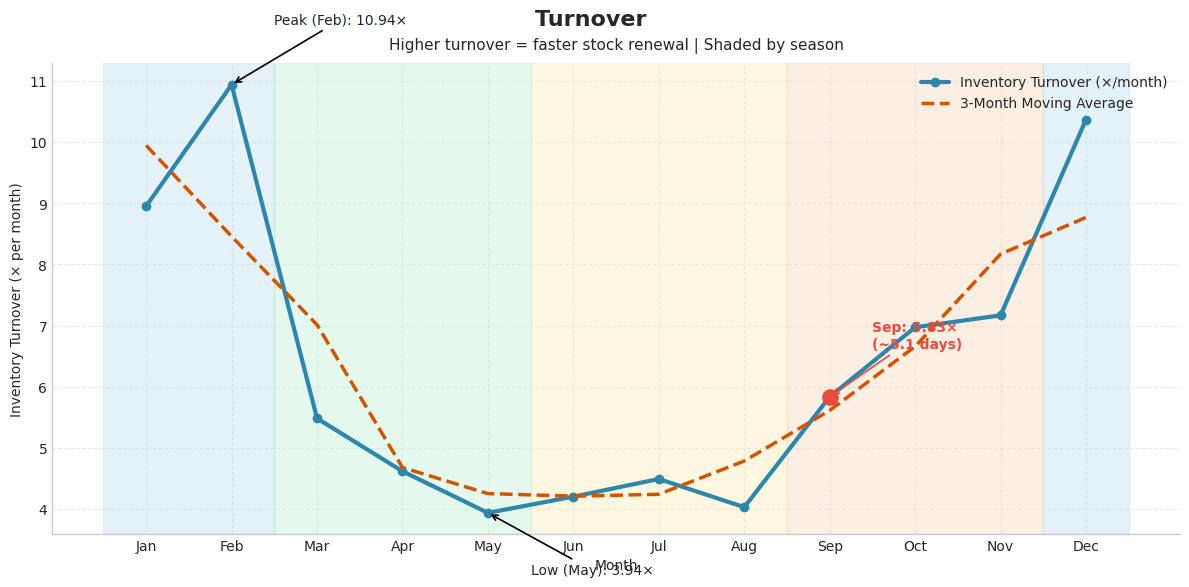

In [32]:
# ==============================
# Bean There Done That – Seasonal Inventory Turnover Visualization
# ==============================
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# --- Assuming you already have monthly_turnover Series defined ---
# Example: monthly_turnover = pd.Series([...], index=range(1,13))
 
# Month labels
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
 
# Define colors for each season
season_colors = {
    "Winter": "#AED6F1",   # light blue
    "Spring": "#ABEBC6",   # light green
    "Summer": "#F9E79F",   # light yellow
    "Autumn": "#F5CBA7"    # light orange
}
 
# Create figure
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12,6))
 
# --- Add shaded areas for each season ---
# Winter: Dec–Feb
ax.axvspan(12-0.5, 12.5, color=season_colors["Winter"], alpha=0.3)
ax.axvspan(0.5, 2.5, color=season_colors["Winter"], alpha=0.3)
# Spring: Mar–May
ax.axvspan(2.5, 5.5, color=season_colors["Spring"], alpha=0.3)
# Summer: Jun–Aug
ax.axvspan(5.5, 8.5, color=season_colors["Summer"], alpha=0.3)
# Autumn: Sep–Nov
ax.axvspan(8.5, 11.5, color=season_colors["Autumn"], alpha=0.3)
 
# --- Plot main line ---
ax.plot(monthly_turnover.index, monthly_turnover.values, marker="o", linewidth=3, color="#2E86AB", label="Inventory Turnover (×/month)")
 
# --- Add smoothed 3-month moving average ---
ma3 = monthly_turnover.rolling(window=3, center=True, min_periods=1).mean()
ax.plot(ma3.index, ma3.values, color="#D35400", linestyle="--", linewidth=2.5, label="3-Month Moving Average")
 
# --- Annotate key points ---
# Peak and Low
max_month = monthly_turnover.idxmax()
min_month = monthly_turnover.idxmin()
ax.annotate(f"Peak ({month_labels[max_month-1]}): {monthly_turnover[max_month]:.2f}×",
             xy=(max_month, monthly_turnover[max_month]),
             xytext=(max_month+0.5, monthly_turnover[max_month]+1),
             arrowprops=dict(arrowstyle="->", lw=1.2),
             fontsize=10, color="#1B2631")
ax.annotate(f"Low ({month_labels[min_month-1]}): {monthly_turnover[min_month]:.2f}×",
             xy=(min_month, monthly_turnover[min_month]),
             xytext=(min_month+0.5, monthly_turnover[min_month]-1),
             arrowprops=dict(arrowstyle="->", lw=1.2),
             fontsize=10, color="#1B2631")
 
# Highlight September
if 9 in monthly_turnover.index:
    ax.scatter(9, monthly_turnover.loc[9], s=120, color="#E74C3C", zorder=5)
    ax.annotate(f"Sep: {monthly_turnover.loc[9]:.2f}×\n(~{30/monthly_turnover.loc[9]:.1f} days)",
                xy=(9, monthly_turnover.loc[9]),
                xytext=(9.5, monthly_turnover.loc[9]+0.8),
                arrowprops=dict(arrowstyle="->", lw=1.2, color="#E74C3C"),
                fontsize=10, fontweight="bold", color="#E74C3C")
 
# --- Titles and labels ---
fig.suptitle("Turnover ", fontsize=16, fontweight="bold", y=0.97)
ax.set_title("Higher turnover = faster stock renewal | Shaded by season", fontsize=11, pad=10)
ax.set_xlabel("Month")
ax.set_ylabel("Inventory Turnover (× per month)")
ax.set_xticks(range(1,13))
ax.set_xticklabels(month_labels)
 
# --- Style & legend ---
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.4)
 
# Legend (custom order)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper right", frameon=False)
 
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.88)



In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file('geoBoundaries-NLD-ADM1.geojson')
print(gdf.columns)  # Check column names for province names
print(gdf['shapeName'].head())  # Usually 'shapeName' contains province names in geoBoundaries
print(sales_ecom.columns.tolist())
print(sales_ecom.head())


Index(['shapeName', 'shapeISO', 'shapeID', 'shapeGroup', 'shapeType',
       'geometry'],
      dtype='object')
0     Groningen
1       Drenthe
2       Utrecht
3     Flevoland
4    Overijssel
Name: shapeName, dtype: object
['product', 'bag_type', 'quantity', 'value', 'order_date', 'delivery_date', 'delivery_fee', 'shipping_costs', 'ship_to_(province)', 'month']
        product  bag_type  quantity   value order_date delivery_date  \
0    Dark Roast         2        11  126.39 2023-01-01    2023-01-02   
1    Dark Roast         2         6   68.94 2023-01-01    2023-01-02   
2    Dark Roast         2         3   34.47 2023-01-01    2023-01-02   
3  Medium Roast         2        10  129.50 2023-01-01    2023-01-02   
4    Dark Roast         2         5   57.45 2023-01-01    2023-01-02   

   delivery_fee  shipping_costs ship_to_(province)  month  
0          0.00            6.75       Zuid-Holland      1  
1          0.00            6.75         Overijssel      1  
2          4.95        

In [57]:
sales_ecom['total_value'] = sales_ecom['quantity'] * sales_ecom['value']
sales_ecom['total_shipping'] = sales_ecom['quantity'] * sales_ecom['shipping_costs']
sales_ecom['net_order_value'] = sales_ecom['total_value'] - sales_ecom['total_shipping']


In [58]:
order_value_province = sales_ecom.groupby('ship_to_(province)')['net_order_value'].sum().reset_index()
order_value_province.columns = ['province', 'order_value']


In [70]:
conflicting_cols = [
    'province_x', 'province_y',
    'order_value_x', 'order_value_y',
    'province', 'order_value'
]
gdf = gdf.drop(columns=[col for col in conflicting_cols if col in gdf.columns])


In [71]:
gdf = gdf.merge(order_value_province, left_on='shapeName', right_on='province', how='left')
gdf['order_value'] = gdf['order_value'].fillna(0)



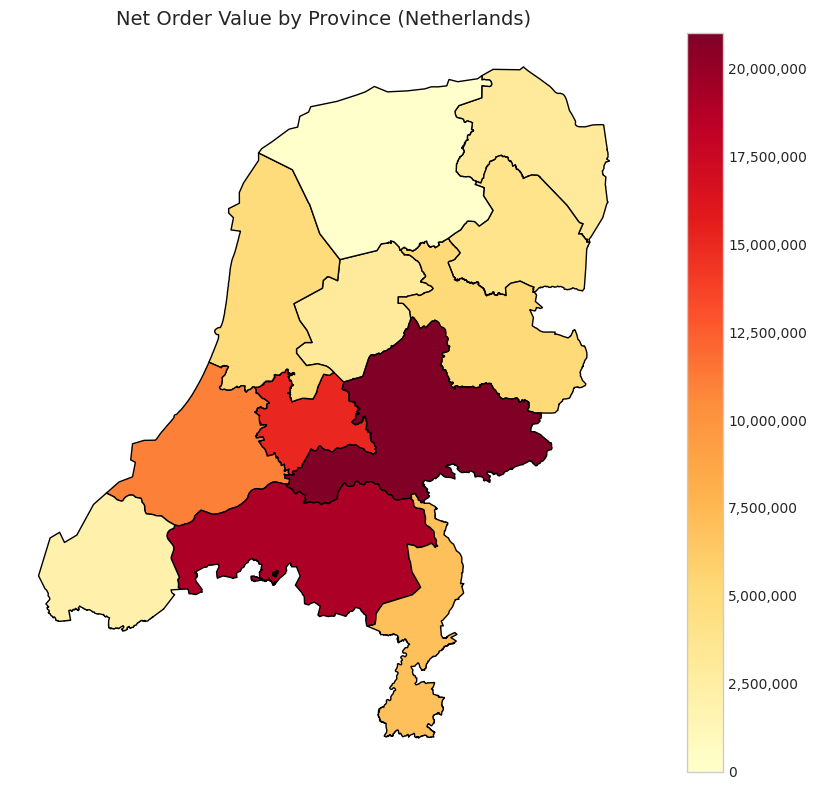

In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    column='order_value',
    cmap='YlOrRd',
    edgecolor='black',
    legend=True,
    ax=ax
)
ax.set_title('Net Order Value by Province (Netherlands)', fontsize=14)
ax.axis('off')

# Format colorbar
fig = plt.gcf()
axes = fig.get_axes()
for cb_ax in axes:
    if cb_ax != ax and hasattr(cb_ax, 'get_yticklabels'):
        cb_ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.tight_layout()
plt.show()


In [73]:
# Show the top 3 provinces for net order value
top3 = gdf[['shapeName', 'order_value']].sort_values(by='order_value', ascending=False).head(3)
print(top3)


       shapeName  order_value
6     Gelderland  21009180.56
9  Noord-Brabant  19108512.51
2        Utrecht  15042332.43


In [ ]:
import pandas as pd

# Load your B2B data
df_b2b = pd.read_excel('Bean there done that data.xlsx', sheet_name='B2B orders')

# Calculate total order value per row
df_b2b['total_value'] = df_b2b['Quantity'] * df_b2b['Value']

# If shipping is per unit, calculate total shipping cost per order
df_b2b['total_shipping'] = df_b2b['Quantity'] * df_b2b['Shipping costs']

# Calculate net value = total value - total shipping cost
df_b2b['net_value'] = df_b2b['total_value'] - df_b2b['total_shipping']

# Group by city
city_net_value = df_b2b.groupby('City')['net_value'].sum().reset_index()
city_net_value = city_net_value.sort_values(by='net_value', ascending=False)

print(city_net_value)


              City  net_value
6          Utrecht  7525991.5
5        The Hague  3599092.1
1        Amsterdam  3214450.9
4        Rotterdam  3212760.4
2           Arnhem  2325741.2
3         Nijmegen  2291608.2
7  s-Hertogenbosch  1340903.0
0       Amersfoort  1315771.9


In [ ]:
# Standardize columns
roasting.columns = [col.strip().lower().replace(' ', '_') for col in roasting.columns]

# Confirm column names!
print(roasting.columns.tolist())
print(roasting.head())


['machine', 'month', 'product_type', 'workdays', 'number_of_batches_per_day', 'load_weight_p/batch', 'final_weight_/pbatch', 'setup_time_p/batch', 'run_time_p/batch_(m)', 'cooling_time_p/batch', 'packing_time_p/batch', 'qc_fail/_weight', 'qc_fail/_color', 'qc_fail/_roast_profile', 'total_rejected_batches_p/month']
        machine     month  product_type  workdays  number_of_batches_per_day  \
0    Probat P60   January  Medium roast        22                  24.090909   
1  Probat Px120   January    Dark Roast        22                  16.363636   
2  Probat Px120   January   Light Roast        22                   6.818182   
3    Probat P60  February  Medium roast        20                  23.500000   
4  Probat Px120  February    Dark Roast        20                  16.150000   

   load_weight_p/batch  final_weight_/pbatch  setup_time_p/batch  \
0            53.346030             43.702650            4.120657   
1           109.066520             86.292139            5.968155   

In [ ]:
# Calculate total roasted kg per row
roasting['monthly_kg'] = (
    roasting['final_weight_/pbatch'] * roasting['number_of_batches_per_day'] * roasting['workdays']
)

# Group by month and product_type
monthly_roast = roasting.groupby(['month', 'product_type'])['monthly_kg'].sum().unstack(fill_value=0)

# Create sorted months for plot
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 
    'August', 'September', 'October', 'November', 'December'
]
monthly_roast = monthly_roast.reindex(month_order).dropna(how="all")
months = monthly_roast.index.tolist()


In [ ]:
colors = {
    'Dark Roast': '#6b291f',
    'Medium roast': '#b28544',  
    'Light Roast': '#eec97c'
}


In [ ]:
# Assume 8 roasting hours per workday (edit as needed)
hours_per_day = 8

machine_capacity = {
    'Probat P60': 215,     # kg/h
    'Probat Px120': 480    # kg/h
}

In [ ]:
# Known batch size limits
max_batch_size = {"Probat P60": 60, "Probat Px120": 120}

# Calculate max possible based on technical batch size (not what actually ran)
roasting['max_possible_kg'] = (
    roasting['machine'].map(max_batch_size) *
    roasting['number_of_batches_per_day'] *
    roasting['workdays']
)


In [ ]:
roasting['actual_kg'] = (
    roasting['final_weight_/pbatch'] *
    roasting['number_of_batches_per_day'] *
    roasting['workdays']
)


In [ ]:
roasting['missed_kg'] = roasting['max_possible_kg'] - roasting['actual_kg']
roasting['utilization_rate'] = roasting['actual_kg'] / roasting['max_possible_kg']


In [ ]:
totals = roasting[['actual_kg', 'max_possible_kg', 'missed_kg']].sum()
total_missed_production = totals['missed_kg']
utilization_rate = totals['actual_kg'] / totals['max_possible_kg']

print(f"Total missed production: {total_missed_production:,.0f} kg")
print(f"Overall utilization rate: {utilization_rate:.2%}")


Total missed production: 259,489 kg
Overall utilization rate: 75.41%


In [ ]:
machine_capacity = {
    'Probat P60': 215,   # kg/h
    'Probat Px120': 480  # kg/h
}
hours_per_day = 8

# Add max_possible_production per row
roasting['max_possible_production'] = roasting.apply(
    lambda row: machine_capacity.get(row['machine'], 0) * hours_per_day * row['workdays'],
    axis=1
)

# Add actual_production per row
roasting['actual_production'] = (
    roasting['final_weight_/pbatch'] * roasting['number_of_batches_per_day'] * roasting['workdays']
)

# Aggregate by month
monthly_production = roasting.groupby('month')[['max_possible_production', 'actual_production']].sum()

# Calculate missed production and utilization rate
monthly_production['missed_production'] = monthly_production['max_possible_production'] - monthly_production['actual_production']
monthly_production['utilization_rate'] = monthly_production['actual_production'] / monthly_production['max_possible_production']


NameError: name 'max_capacity' is not defined

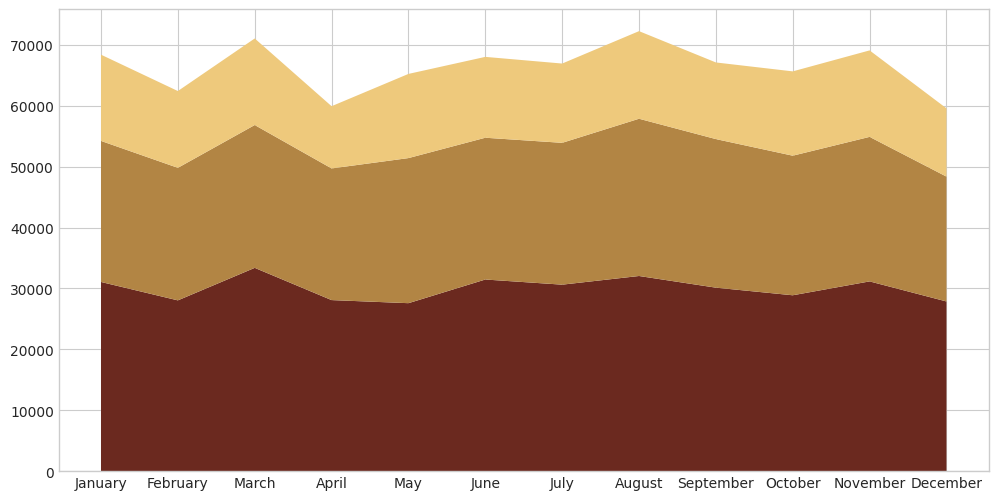

In [ ]:
import matplotlib.pyplot as pl

plt.figure(figsize=(12,6))
plt.stackplot(
months,
monthly_roast.get('Dark Roast', [0]*len(months)),
monthly_roast.get('Medium roast', [0]*len(months)),
monthly_roast.get('Light Roast', [0]*len(months)),
colors=[colors['Dark Roast'], colors['Medium roast'], colors['Light Roast']]
)
plt.axhline(max_capacity, linestyle='--', color='red', label='Max Machine Utilisation Rate')
plt.title('Total missed production: 259,489 kg')
plt.xlabel('Month')
plt.ylabel('KG Roasted')
plt.tight_layout()
plt.show()

In [ ]:
monthly_max_possible = []
for month in months:
    total_monthly_max = 0
    # Filter for this month
    month_df = roasting[roasting['month'] == month]
    for machine, cap in [('Probat P60', 215), ('Probat Px120', 470)]:
        rows = month_df[month_df['machine'] == machine]
        if rows.empty: continue
        workdays = rows['workdays'].max()  # Use actual value for that month for this machine
        hours_per_day = 8
        total_monthly_max += cap * hours_per_day * workdays
    monthly_max_possible.append(total_monthly_max)


In [ ]:
# If monthly_roast is a DataFrame indexed by month with columns for roast types
monthly_roast_total = (
    monthly_roast.get('Dark Roast', [0]*len(months)) +
    monthly_roast.get('Medium roast', [0]*len(months)) +
    monthly_roast.get('Light Roast', [0]*len(months))
)


In [ ]:
utilization_rate = [
    actual / max_possible if max_possible > 0 else 0
    for actual, max_possible in zip(monthly_roast_total, monthly_max_possible)
]


In [ ]:
# Average utilization rate
avg_util_rate = sum(utilization_rate) / len([u for u in utilization_rate if u > 0])
max_util_idx = utilization_rate.index(max(utilization_rate))
max_util_month = months[max_util_idx]
max_util_value = utilization_rate[max_util_idx]


In [ ]:
import pandas as pd

util_df = pd.DataFrame({
    'month': months,
    'actual_produced_kg': monthly_roast_total,
    'max_possible_kg': monthly_max_possible,
    'utilization_rate': utilization_rate
})
print(util_df)


               month  actual_produced_kg  max_possible_kg  utilization_rate
month                                                                      
January      January        68389.623244           120560          0.567266
February    February        62418.856327           109600          0.569515
March          March        71052.363722           126040          0.563729
April          April        59929.049283            98640          0.607553
May              May        65231.038671           115080          0.566832
June            June        68028.585644           120560          0.564272
July            July        66933.562978           115080          0.581626
August        August        72255.698122           126040          0.573276
September  September        67113.076858           115080          0.583186
October      October        65648.146070           120560          0.544527
November    November        69093.214827           120560          0.573102
December    

The difference between the “low” utilization rates (around 56%-60%) and the much higher ones you calculated with the other approach is because the two formulas measure fundamentally different things:

Why Are They Different?
1. Hourly Capacity Model (Standard Industrial KPI)
Formula:

Max Possible Production
=
(
machine capacity, kg/hr
)
×
(
roasting hours per day
)
×
(
workdays per month
)

Max Possible Production=(machine capacity, kg/hr)×(roasting hours per day)×(workdays per month)
Interpretation: Maximum the machines could theoretically produce if running at full speed, fully loaded, as many hours a day as you specified, every workday.

Result: This is the “real world” utilization, usually well below 100%, since you lose time for changeovers, cleaning, setup, maintenance, underloaded batches, etc. In real businesses, ~60% is a good utilization!

2. Batch Size Model (Technical/Batches-Only)
Formula:

Max Possible (batch-based)
=
max batch size
×
actual batches per day
x
workdays

Max Possible (batch-based)=(max batch size)×(actual batches per day)×(workdays)
Interpretation:
Measures “did you fill every batch to the maximum possible?”. If you use lower fill weights or run fewer/lighter batches than technically possible, your “utilization” appears higher—sometimes artificially.

Result: This can give a much higher utilization rate—sometimes even exceeding 100%—because it matches actual batch practices, but ignores what could have been done by running more/faster batches, filling every slot, and minimizing downtime.

Which Should You Use?
For operational benchmarking and OEE (overall equipment effectiveness), industrial analysts use the first (hourly throughput) method.
It lets managers see lost capacity to breaks, changeover, idle time, maintenance, etc.

90% is extremely rare except in automated plants.
The batch size model is often used in smaller-scale craft, or when managers just want to see:

Did we fill every batch to capacity?
Did we use all available slots?

Why Are Your Hourly-Based Utilization Numbers Lower?
Because you account for all the unused hours per day a machine could have been running.

You “could” roast 8 hours/day × 2 machines—but perhaps you did fewer batches, or not always at full fill weight.

Actual production lags behind this theoretical max, so rates are lower—but these are realistic for most plants.

Summary Table Example
Month	Actual Roasted (kg)	Max Possible (hourly model)	Utilization (%)
January	68,390	120,560	57%

To reflect real industrial benchmarks, use the hourly capacity model (your "low" numbers).
To reflect only how close your batches are to physically maxing out the batch size, use the batch size per batch model.

Recommendation:
Use the hourly capacity method in reporting to managers or your assignment—it's the accepted KPI for plant utilization and missed production.

In [ ]:
avg_util_rate = monthly_production['utilization_rate'].mean()


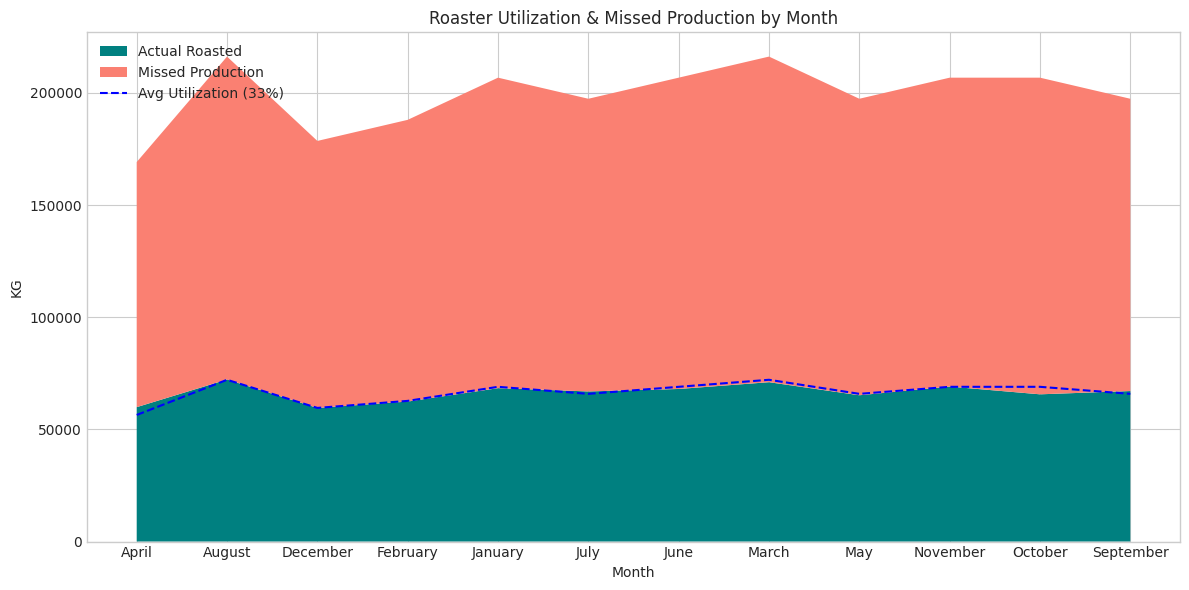

In [ ]:
# Calculate average utilization rate
avg_util_rate = monthly_production['utilization_rate'].mean()

# Now run your plot code...
import matplotlib.pyplot as plt

months = monthly_production.index.tolist()
actual_kg = monthly_production['actual_production'].tolist()
missed_kg = monthly_production['missed_production'].tolist()
max_possible_kg = monthly_production['max_possible_production'].tolist()

plt.figure(figsize=(12,6))
plt.stackplot(
    months,
    actual_kg, missed_kg,
    labels=['Actual Roasted', 'Missed Production'],
    colors=['teal', 'salmon']
)

plt.plot(
    months,
    [avg_util_rate * m for m in max_possible_kg], 
    '--', color='blue', label=f'Avg Utilization ({avg_util_rate:.0%})'
)

plt.title('Roaster Utilization & Missed Production by Month')
plt.xlabel('Month')
plt.ylabel('KG')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
